# Imports

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# JSON to Dataframe made simple
from pandas.io.json import json_normalize

from fbprophet import Prophet

# Data Loading

This data was taken from a PECO premise. All available usage data for the premise was exported to JSON format from the ICap database.

In [2]:
# Read into the JSON records
import json
with open('single_premise_history.json') as f:
    data = json.load(f)
    data = json_normalize(data, 'records')

print(data.shape)
data.describe(include='all')

(17354, 3)


,HourEnding,Usage,UsageDate
count,17354.000000,17354.000000,17354
unique,NaN,NaN,721
top,NaN,NaN,2016-09-12
freq,NaN,NaN,49
mean,12.501441,0.368565,NaN
std,6.923288,0.229373,NaN
min,1.000000,-0.017290,NaN
25%,7.000000,0.187000,NaN
50%,13.000000,0.373000,NaN
75%,19.000000,0.499000,NaN


# Data Munging

1. Adjust the datetime stamp to have the form `YYYY-MM-DD HH:MM:SS`
2. Select the maximum value per day
3. Split into training and validation sets

### 1. Adjusting datetime format

In [3]:
# Convert hours to pd.Timedelta
data['Hour'] = data['HourEnding'].apply(lambda x: pd.Timedelta(hours=x))

# Convert string dates to DateTime
data['UsageDate'] = data['UsageDate'].apply(lambda x: pd.to_datetime(x))

# Append UsageDate with Hour; YYYY-MM-DD HH:MM:SS
data['Timestamp'] = data['UsageDate'] + data['Hour']

# Drop superflous data
df = data.drop(['UsageDate', 'Hour'], axis=1)

### 2. Selection of daily maximum

In [4]:
# Set timestamp index
# Take daily maximum
# Sort by timestamp
# Unstack
daily_max = df.set_index('Timestamp').groupby(
    pd.TimeGrouper('D')
    ).max().sort_index().reset_index()

# Rename to follow Prophet naming
daily_max.rename(columns={'Timestamp': 'ds', 'Usage': 'y'}, inplace=True)

### 3. Splitting the dataset

In [5]:
# Split the dataset; 2 years historic (2014, 2015); 1 year future (2016)
testing_idx = daily_max[daily_max['ds'].dt.year == 2016].index

training = daily_max.drop(testing_idx)
testing = daily_max.take(testing_idx)

# Training Prophet

In [6]:
# Fit the prophet Model
m = Prophet()
m.fit(training);

In [7]:
# Make the predictions
PERIOD=testing.shape[0]
future = m.make_future_dataframe(periods=PERIOD)
forecast = m.predict(future)

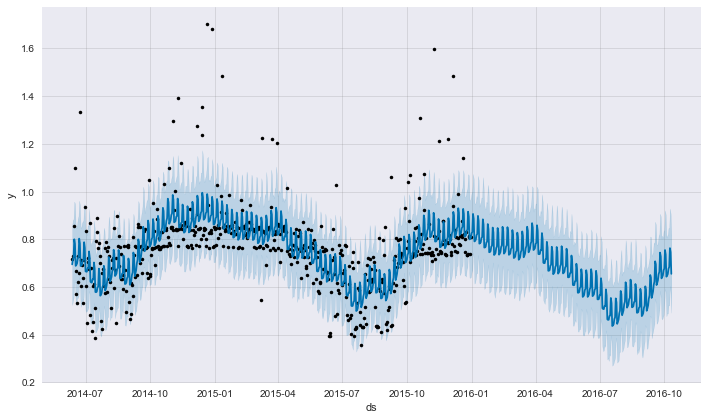

In [8]:
m.plot(forecast);

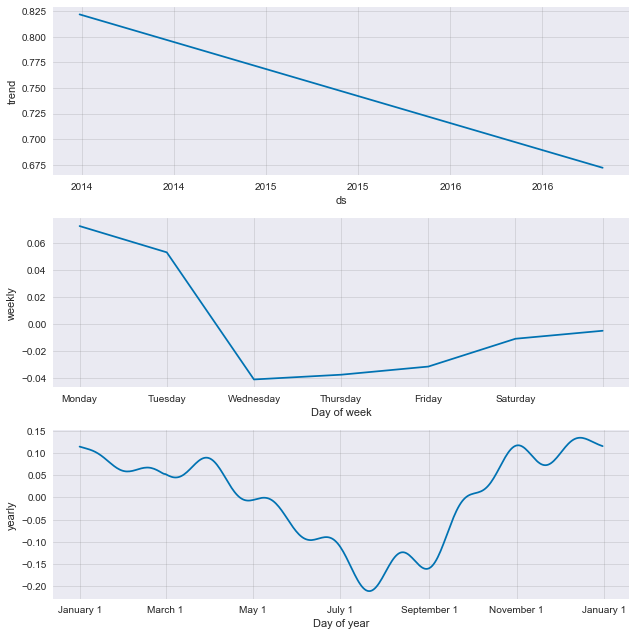

In [9]:
m.plot_components(fcst=forecast, uncertainty=False);

In [10]:
?m.plot_components

### What does those charts indicate?

#### Trend vs. Year
Indication that energy use is decreasing annually.

#### Weekly vs. Day of Week
Monday and Tuesday usage values are significantly higher then the 
remaing days of the week.

#### Yearly vs Day of Year
Annual distribution over the training period. The indications is that the particular customer utilizes more energy during winter months versus summer months. This data must not come from Texas.

# How does the forecast compare to the testing set?

In [11]:
merged = pd.merge(forecast, testing, on='ds');
merged.dropna(subset=['y'], inplace=True)
merged.drop([0], inplace=True)


x, yhatL, yhatU, yhat, y = merged[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'y']].as_matrix().T

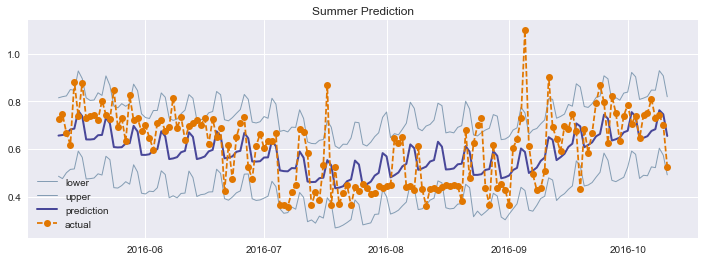

In [12]:
sns.color_palette('Paired')
fig, (ax) = plt.subplots(1, 1, figsize=(12,4))


plt.plot(x, yhatL, alpha=0.7, color=sns.xkcd_rgb['steel blue'], lw=1)
plt.plot(x, yhatU, alpha=0.7, color=sns.xkcd_rgb['steel blue'], lw=1)
#ax.errorbar(x, yhat, yerr=[yhat - yhatL, yhatU-yhat], color=sns.xkcd_rgb['steel blue'])
plt.plot(x, yhat, alpha=0.7, color=sns.xkcd_rgb['deep blue'], lw=2)
plt.plot(x, y, 'k--', color=sns.xkcd_rgb['pumpkin'], marker='o')
plt.legend(['lower', 'upper', 'prediction', 'actual'], loc='lower left')
plt.title('Summer Prediction');


### Summer Prediction Inspection
Over the course of the summer the overall performance is fantastic. Most of the known values (orange) fall within the prediction band of the `Prophet` generated model.

# What about those outliers?

In [13]:
# if upper - actual is negative, consider the usage an outlier
def test_outlier(row):
    actual = row['y']
    upper = row['yhat_upper']
    is_outlier = upper - actual < 0
    if is_outlier:
        return True
    return False

    
# Test for outliers
merged['Outliers'] = merged.apply(test_outlier, axis=1)

In [14]:
# Extract the outliers
outliers = merged[merged['Outliers']][['ds', 'yhat_upper', 'y', 'HourEnding']]

# Compute variance between actual and upper bound
outliers['Error %'] = (outliers['y'] - outliers['yhat_upper']) / outliers['y'] * 100

# What percentage was outside the bounds?
out_rows = outliers.shape[0]
tot_rows = merged.shape[0]
percent = out_rows / tot_rows * 100.0

print('Total Predictions: %d' % tot_rows)
print('Outside Upper Bound: %d' % out_rows)
print('Percentage Outside Upper Bound: %6.3f%%' % percent)

Total Predictions: 155
Outside Upper Bound: 11
Percentage Outside Upper Bound:  7.097%
